# Graphic Statics III: Compression Form Finding through Subdivision

reference: 
https://www.block.arch.ethz.ch/brg/files/AKBARZADEH_2015_IASS_subdivision_3d_1442567115.pdf

In [1]:
import math as m

import compas
import compas_ags

from compas_ags.diagrams import FormGraph
from compas_ags.diagrams import FormDiagram
from compas_ags.diagrams import ForceDiagram
from compas_ags.ags import graphstatics
from compas_ags.viewers import Viewer

import warnings
warnings.filterwarnings("ignore")

###    create force and form diagrams of an arch

In [2]:
### 
###  INPUT HOW MANY LOADS TO ADD
###
loads = 3

length = 10
type = 'arch'

In [3]:
# create a catenary curve
def catenary_curve(x, type='arch', a=5, xm=0, ym=0):
    if type is 'arch':
        return ym - a * m.cosh((x - xm) / a)
    elif type is 'hanging_cable':
        return ym + a * m.cosh((x - xm) / a)

# create an arch from nodes and edges
nodes = []
edges = []

# add cable lines
for i in range(loads + 2):
    x = i * length / (loads + 1) - length / 2 
    y = catenary_curve(x, type=type)
    nodes.append([x, y, 0])
    if i != loads + 1 : edges.append(tuple([i, i+1])) 
        
loads_uv = []
# add vertical load lines and rection force lines
for i in range(loads + 2):
    if i == 0 or i == loads + 1 :
        x = i * length / (loads + 1) - length / 2 
        y = catenary_curve(x, type=type) - 1.0
        nodes.append([x, y, 0])
    else:
        x = i * length / (loads + 1) - length / 2 
        y = catenary_curve(x, type=type) + 1.0
        nodes.append(([x, y, 0]))
        loads_uv.append(tuple([i, i + loads + 2]))
    edges.append(tuple([i, i + loads + 2]))
        
# add horizontal rection force lines
nodes.append([- length / 2 - 1.0, catenary_curve(-length / 2, type=type), 0])
edges.append(tuple([0, len(nodes) - 1]))

nodes.append([length / 2 + 1.0, catenary_curve(length / 2, type=type), 0])
edges.append(tuple([loads + 1, len(nodes) - 1]))

In [4]:
# make form and force diagrams
graph = FormGraph.from_nodes_and_edges(nodes, edges)
form = FormDiagram.from_graph(graph)
force = ForceDiagram.from_formdiagram(form)

In [5]:
# set the magnitude of the applied load
e =  {'v': list(form.vertices_where({'x': - length / 2, 'y': catenary_curve(-length / 2, type=type)}))[0],
       'u': list(form.vertices_where({'x': - length / 2 -1.0, 'y': catenary_curve(-length / 2, type=type)}))[0]}

form.edge_attribute((e['u'], e['v']), 'is_ind', True)
form.edge_attribute((e['u'], e['v']), 'q', -5.)

# set the fixed points
left = list(form.vertices_where({'x': - length / 2, 'y': catenary_curve(-length / 2, type=type)}))[0]
right = list(form.vertices_where({'x': length / 2, 'y': catenary_curve(length / 2, type=type)}))[0]
fixed = [left, right]
form.set_fixed(fixed)
force.set_anchor([0])

# update the diagrams
graphstatics.form_update_q_from_qind(form)
graphstatics.force_update_from_form(force, form)

In [6]:
# store lines representing the current state of equilibrium
form_lines = []
for u, v in form.edges():
    form_lines.append({
        'start': form.vertex_coordinates(u, 'xy'),
        'end'  : form.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

form_lines.append({
        'start': form.vertex_coordinates(0, 'xy'),
        'end'  : form.vertex_coordinates(loads + 1, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

force_lines = []
for u, v in force.edges():
    force_lines.append({
        'start': force.vertex_coordinates(u, 'xy'),
        'end'  : force.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

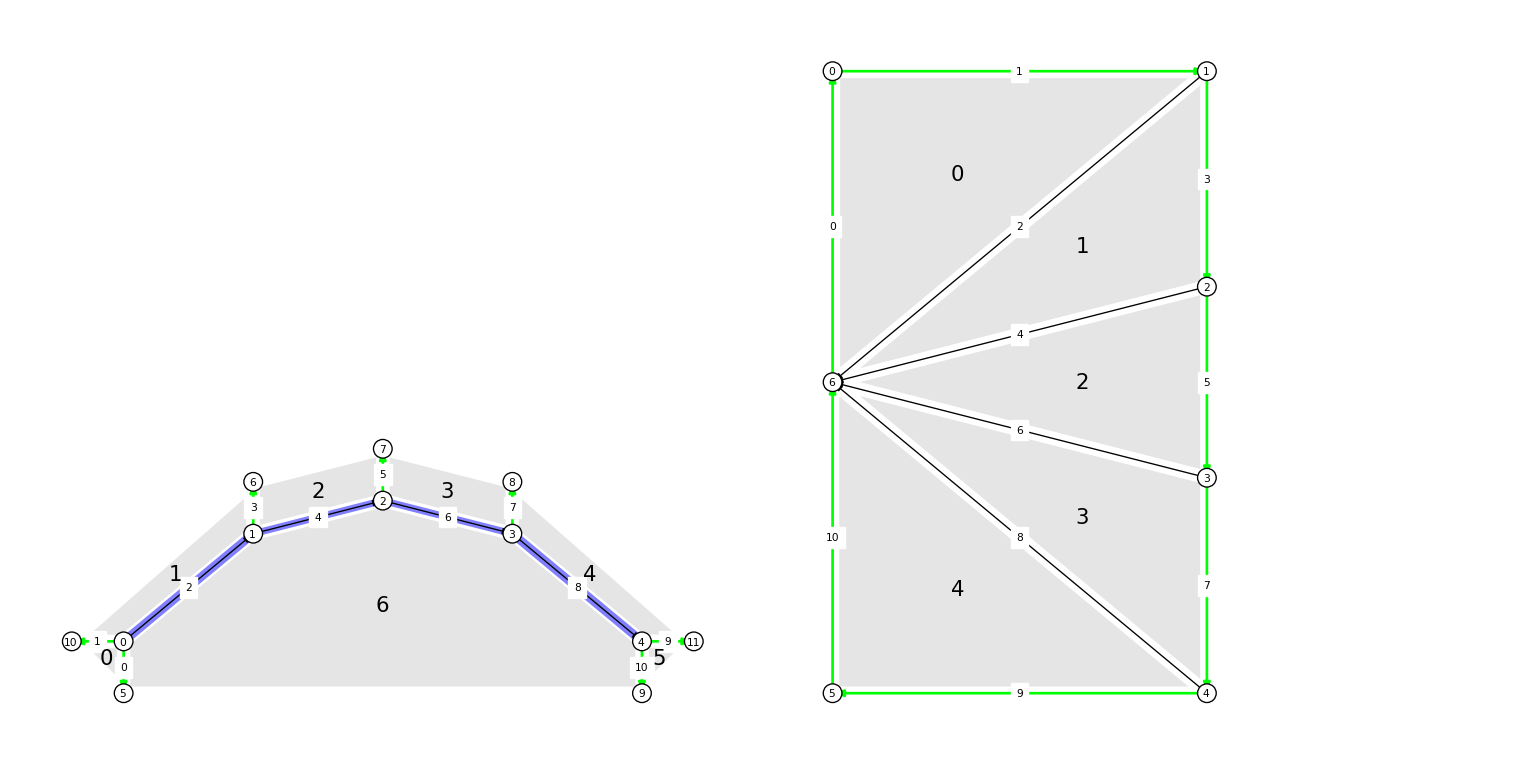

In [7]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=True,
    faces_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in form.vertices()},
    edgelabel={uv: index for index, uv in enumerate(form.edges())},)

    
viewer.draw_force(
    arrows_on=True,
    faces_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in force.vertices()},
    edgelabel=viewer.check_edge_pairs()[1])

viewer.show()

The form and force diagrams have a face-dual relationship with each other. 
<br>
The vertices in one diagram corresponds to the faces of the other diagram. 

###    subdivide the force digram

In [8]:
def subdivide_force_tri(form, force):
    # get the support / fixed bertices in the form diagram
    # they are faces that should not be subdivided in the force diagram
    
    #================================================================
    # THIS NEED TO BE CHECKED. WIHCH FACE SHOULD NOT BE SUBDIVIDED? 
    # NOW THE FIXED VKEYS ARE SUPPORTS. 
    # OR CHECKING DEGREE OF THE VERTEX IS A BETTER WAY? 
    #================================================================
    # find fkeys that should not be subdivided
    form_fixed_vertices = [vkey for vkey in form.vertices() if form.vertex_attribute(vkey, 'is_fixed') is True]
    # update force diagram  face attribute to save the origianl fkey
    force.update_default_face_attributes({'ori_fkey': None})
    
    subd = force.copy()
    fkeys_to_del = []
    for fkey in subd.faces():
        force.face_attribute(fkey, 'ori_fkey', fkey) 
        # use duality, fkey of force diagram is vkey of form diagram
        # to subdivide only internal faces
        if fkey not in form_fixed_vertices:
            fkeys_to_del.append(fkey)
            x, y, z = subd.face_centroid(fkey)
            f_cen_key = force.add_vertex(x=x, y=y, z=z)
            for u, v in subd.face_halfedges(fkey):
                force.add_face([u, v, f_cen_key], ori_fkey=fkey)
    
    # delete the original faces
    for fkey_to_del in fkeys_to_del:
        force.delete_face(fkey_to_del)
    
    return fkeys_to_del

In [9]:
force_del_fkeys = subdivide_force_tri(form, force)

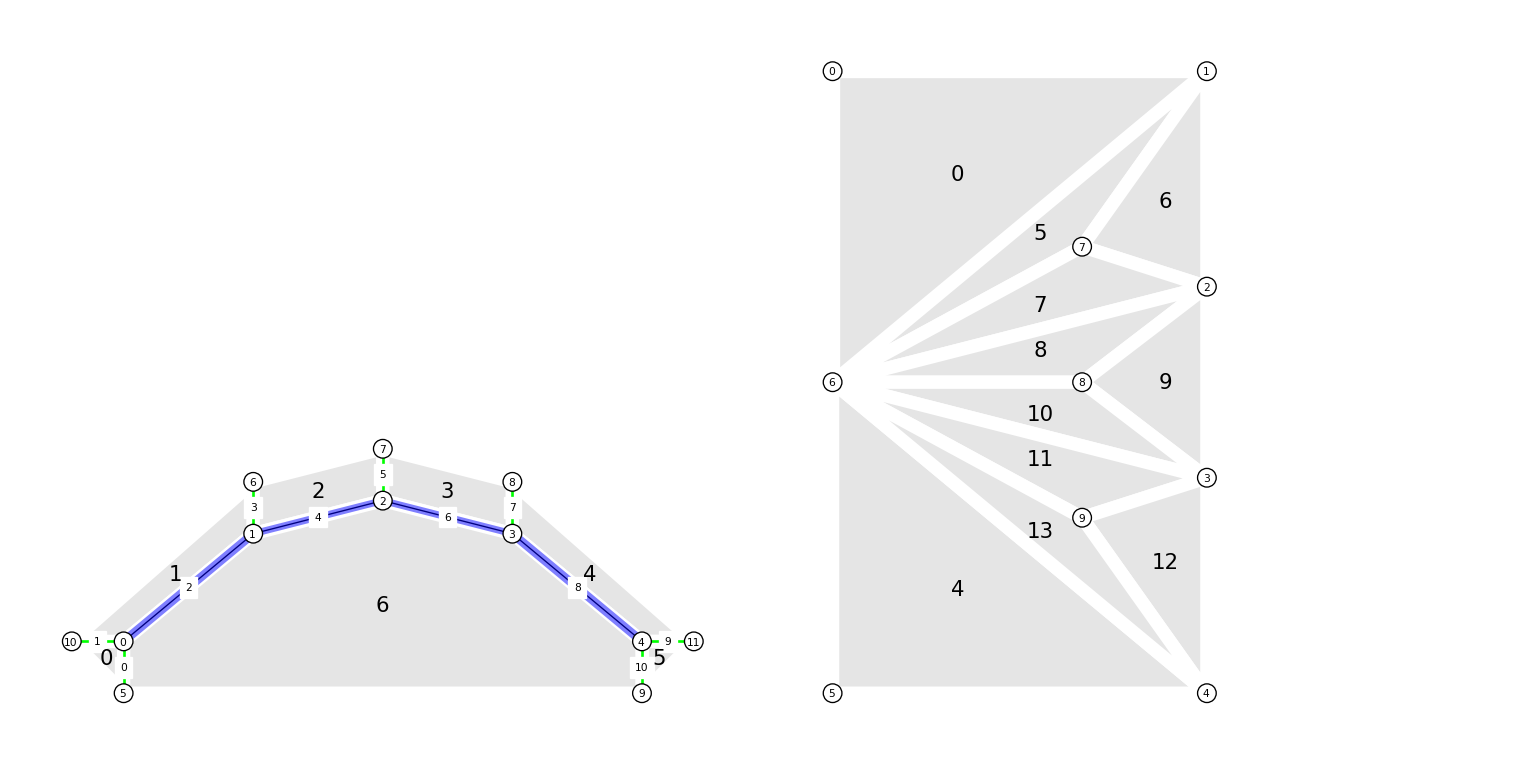

In [10]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=False,
    faces_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in form.vertices()},
    edgelabel={uv: index for index, uv in enumerate(form.edges())},)

    
viewer.draw_force(
    arrows_on=False,
    edges_on=False,
    faces_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in force.vertices()})
#     edgelabel=viewer.check_edge_pairs()[1])

viewer.show()

In [11]:
from compas.geometry import cross_vectors

def get_cycle_direction(vkeys):
    # vkeys should be in cycle, for example face_vertices
    # this function is used to check the cycle direction
    assert len(vkeys) >= 3 # make sure there are at least 3 vertices in the face
    p1 = form.vertex_coordinates(vkeys[0])
    p2 = form.vertex_coordinates(vkeys[1])
    p3 = form.vertex_coordinates(vkeys[2])
    
    v1 = [a - b for a, b in zip(p1, p2)]
    v2 = [a - b for a, b in zip(p3, p2)]
    
    return cross_vectors(v1, v2)

In [12]:
import compas.geometry as cg
### 
###  INPUT SCALE FACTOR IN RANGE (0, 0.5)
###
sca = 0.4   # scale factor in the form diagram

# a nest dictionary of vertex keys
# the internal dictionary keys are face keys connected to the vertex,
# and values are the new edge uv that would replace the vertex in counterclockwise direction
vkey_dict = {}

mesh_direction = get_cycle_direction(form.face_vertices(form.get_any_face()))
print(mesh_direction, 'original direction')

# vertices to modify in form diagram are the faces deleted in the force diagram
for vkey in force_del_fkeys:
    print(vkey, 'this is the key to delete')
    # find edges connected to the vertex
    neighbor_vertices = form.vertex_neighbors(vkey, ordered=True)
    print(neighbor_vertices, 'neighbors')
    v_xy = form.vertex_coordinates(vkey)
    new_vkeys = []
    
    # edge dictionary to store the original edge uv and the new vkey
    edges_dict = {}
    for n_vkey in neighbor_vertices:  # CAN THIS PART USING MATRIX? NOW COMPAS.GEOMETRY
        n_xy = form.vertex_coordinates(n_vkey)
        vec = cg.subtract_vectors([*n_xy], [*v_xy])
        vec = cg.scale_vector(vec, sca)
        # target point xy coordinate
        x, y, z = [a + b for a, b in zip([*v_xy], [*vec])] 
        # add new verte
        tar_vkey = form.add_vertex(x=x, y=y, z=z, is_fixed=False)
        new_vkeys.append(tar_vkey)
        
        # store the original uv and new vkey
        edges_dict[(vkey, n_vkey)] = tar_vkey
    print(edges_dict)
    
    # find faces connected to the vertex
    neighbor_faces = form.vertex_faces(vkey, ordered=True)  # TO CHECK: VERTEX_FACES ARE ALWAYS IN THE CLOCKWISE DIRECTION?
    vkey_dict[vkey] = {}
    for n_fkey in neighbor_faces:
        print(n_fkey, 'neighbour_face_key')
        vkey_dict[vkey][n_fkey] = []
        for (u, v) in form.face_halfedges(n_fkey):
            print(u, v, 'these are uvs')
            if (u, v) in edges_dict.keys():
                print(edges_dict[(u, v)])
                vkey_dict[vkey][n_fkey].append(edges_dict[(u, v)])
            elif (v, u) in edges_dict.keys():
                print(edges_dict[(v, u)])
                vkey_dict[vkey][n_fkey].append(edges_dict[(v, u)])
        print(vkey_dict[vkey][n_fkey], 'vkey_dict')
    print(vkey, new_vkeys, 'these are the new keys')
    form.add_face(new_vkeys[::-1]) 

# face_dict stores fkey whose face_vertices are modified and its new face vertices
face_dict = {}
for fkey in form.faces():
    f_vkeys = form.face_vertices(fkey)
    count = 0
    for i, vkey in enumerate(form.face_vertices(fkey)):
        if vkey in vkey_dict.keys():
            print(f_vkeys)
            f_vkeys.pop(i)
            print(f_vkeys)
            f_vkeys.insert(i, vkey_dict[vkey][fkey][0])
            print(f_vkeys)
            f_vkeys.insert(i + 1, vkey_dict[vkey][fkey][1])
            count += 1
    if count != 0:
        face_dict[fkey] = f_vkeys
        
# delete the old faces and add new faces    
for fkey in face_dict.keys():
    form.face[fkey] = face_dict[fkey]

# print(form)
# print(face_dict)
# print(vkey_dict)

[0.0, 0.0, -2.5] original direction
1 this is the key to delete
[0, 6, 2] neighbors
{(1, 0): 12, (1, 6): 13, (1, 2): 14}
6 neighbour_face_key
9 4 these are uvs
4 3 these are uvs
3 2 these are uvs
2 1 these are uvs
14
1 0 these are uvs
12
0 5 these are uvs
5 9 these are uvs
[14, 12] vkey_dict
1 neighbour_face_key
10 0 these are uvs
0 1 these are uvs
12
1 6 these are uvs
13
6 10 these are uvs
[12, 13] vkey_dict
2 neighbour_face_key
6 1 these are uvs
13
1 2 these are uvs
14
2 7 these are uvs
7 6 these are uvs
[13, 14] vkey_dict
1 [12, 13, 14] these are the new keys
2 this is the key to delete
[1, 7, 3] neighbors
{(2, 1): 15, (2, 7): 16, (2, 3): 17}
6 neighbour_face_key
9 4 these are uvs
4 3 these are uvs
3 2 these are uvs
17
2 1 these are uvs
15
1 0 these are uvs
0 5 these are uvs
5 9 these are uvs
[17, 15] vkey_dict
2 neighbour_face_key
6 1 these are uvs
1 2 these are uvs
15
2 7 these are uvs
16
7 6 these are uvs
[15, 16] vkey_dict
3 neighbour_face_key
7 2 these are uvs
16
2 3 these are 

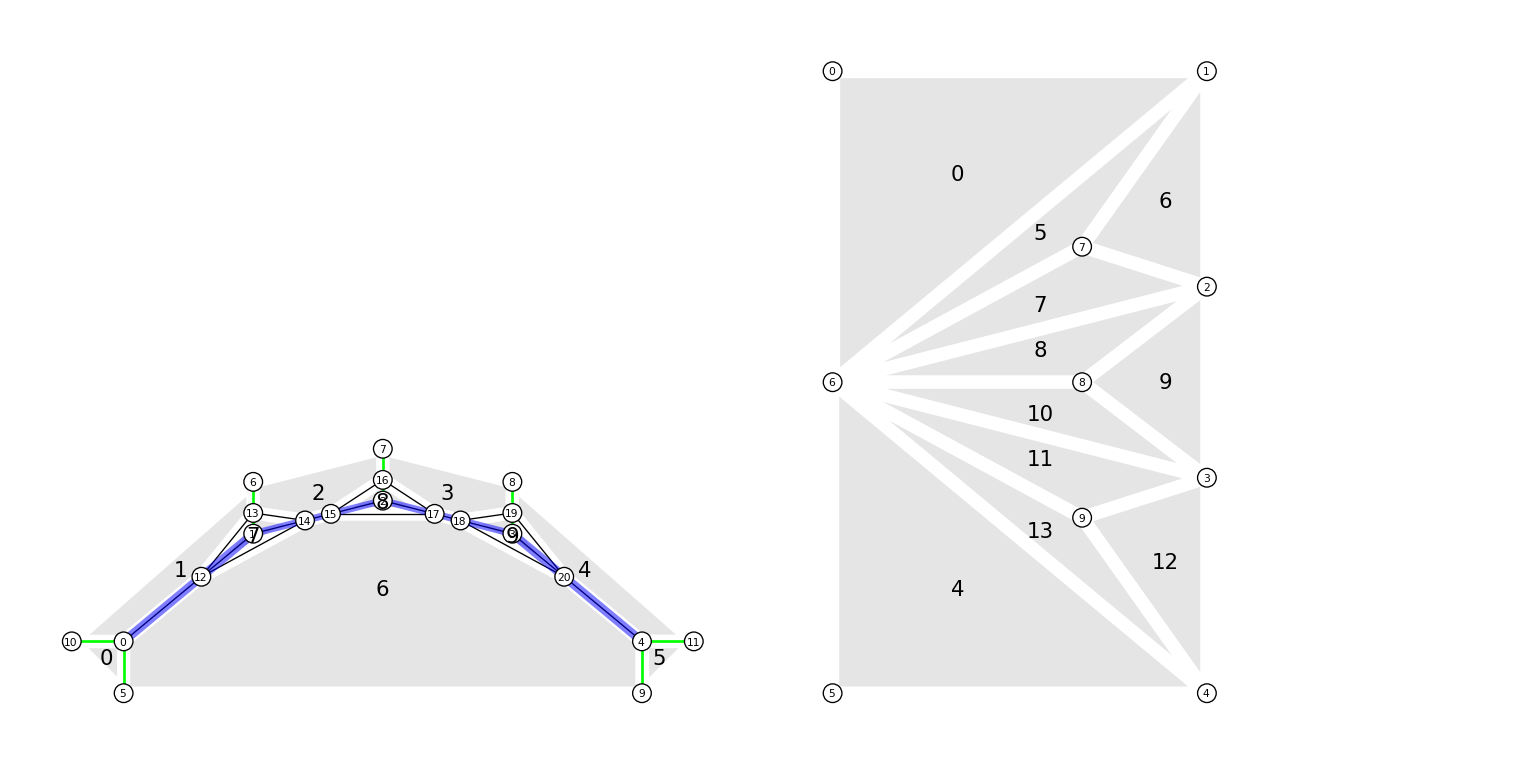

In [13]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=False,
    faces_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in form.vertices()},)

    
viewer.draw_force(
    arrows_on=False,
    edges_on=False,
    faces_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in force.vertices()})

viewer.show()

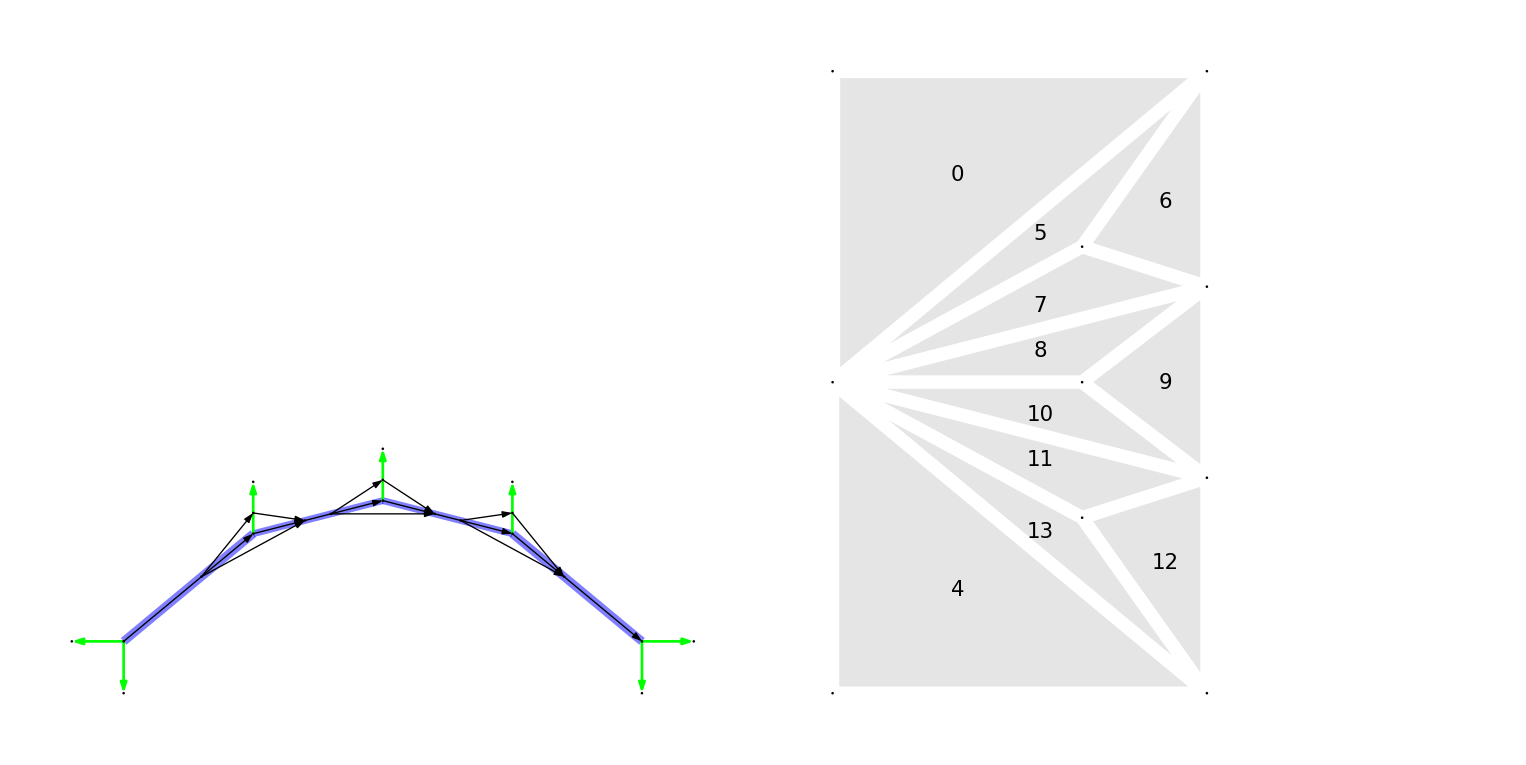

In [14]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=True,
    faces_on=False,
    vertexsize=0.01,)

    
viewer.draw_force(
    arrows_on=True,
    edges_on=False,
    faces_on=True,
    vertexsize=0.01,)

viewer.show()

In [15]:
print(face_dict)
print(vkey_dict)

{1: [10, 0, 12, 13, 6], 2: [6, 13, 14, 15, 16, 7], 3: [7, 16, 17, 18, 19, 8], 4: [8, 19, 20, 4, 11], 6: [9, 4, 20, 18, 17, 15, 14, 12, 0, 5]}
{1: {6: [14, 12], 1: [12, 13], 2: [13, 14]}, 2: {6: [17, 15], 2: [15, 16], 3: [16, 17]}, 3: {6: [20, 18], 3: [18, 19], 4: [19, 20]}}


In [16]:
# it's hard to modify the original form mesh.... cause it's too messy...
# so, let's make a new clean form diagram! 
new_nodes = []
count = 0
vkey_index = {}
for i in range(form.number_of_vertices()):
    vkey = form.key_index()[i]
    if vkey not in force_del_fkeys:
        vkey_index[vkey] = i - count
        new_nodes.append(form.vertex_coordinates(vkey))
    else:
        count += 1

new_faces = [form.face_vertices(fkey) for fkey in form.faces()]
for i, f in enumerate(new_faces):
    new_faces[i] = [vkey_index[v] for v in f]



In [17]:
form = FormDiagram.from_vertices_and_faces(new_nodes, new_faces)
form.edges_attribute('is_edge', False, keys=list(form.edges_on_boundary()))
force = ForceDiagram.from_formdiagram(form)

In [18]:
# set the magnitude of the applied load
e =  {'v': list(form.vertices_where({'x': - length / 2, 'y': catenary_curve(-length / 2, type=type)}))[0],
       'u': list(form.vertices_where({'x': - length / 2 -1.0, 'y': catenary_curve(-length / 2, type=type)}))[0]}
form.edge_attribute((e['u'], e['v']), 'is_ind', True)
form.edge_attribute((e['u'], e['v']), 'q', -5.)

# set the fixed points
left = list(form.vertices_where({'x': - length / 2, 'y': catenary_curve(-length / 2, type=type)}))[0]
right = list(form.vertices_where({'x': length / 2, 'y': catenary_curve(length / 2, type=type)}))[0]
fixed = [left, right]
form.set_fixed(fixed)
force.set_anchor([0])

# update the diagrams
graphstatics.form_update_q_from_qind(form)
graphstatics.force_update_from_form(force, form)

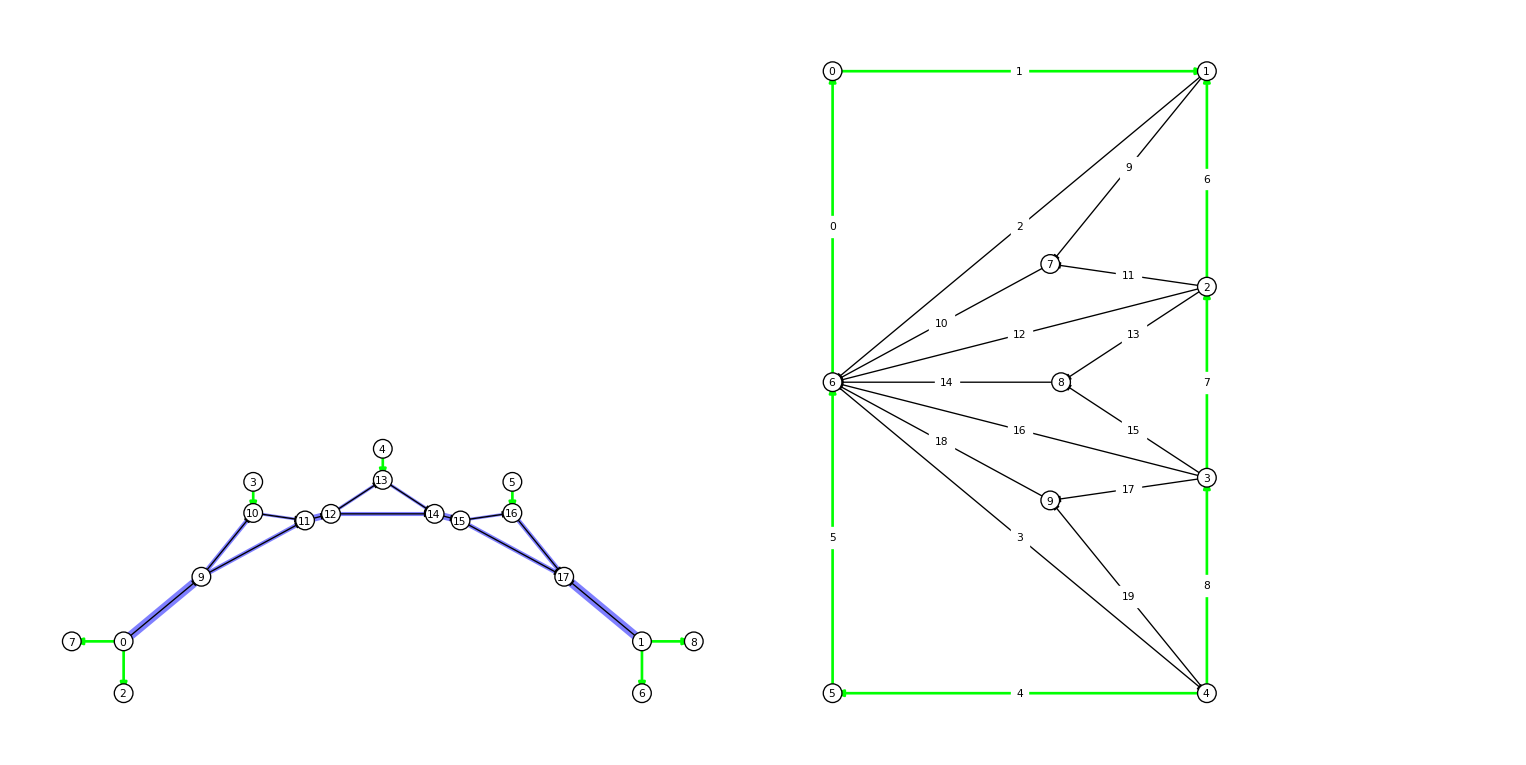

In [19]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=True,
    faces_on=False,
    vertexsize=0.15,
    vertexlabel={key: key for key in form.vertices()},)

    
viewer.draw_force(
    arrows_on=True,
    faces_on=False,
    vertexsize=0.15,
    vertexlabel={key: key for key in force.vertices()},
    edgelabel=viewer.check_edge_pairs()[1])

viewer.show()

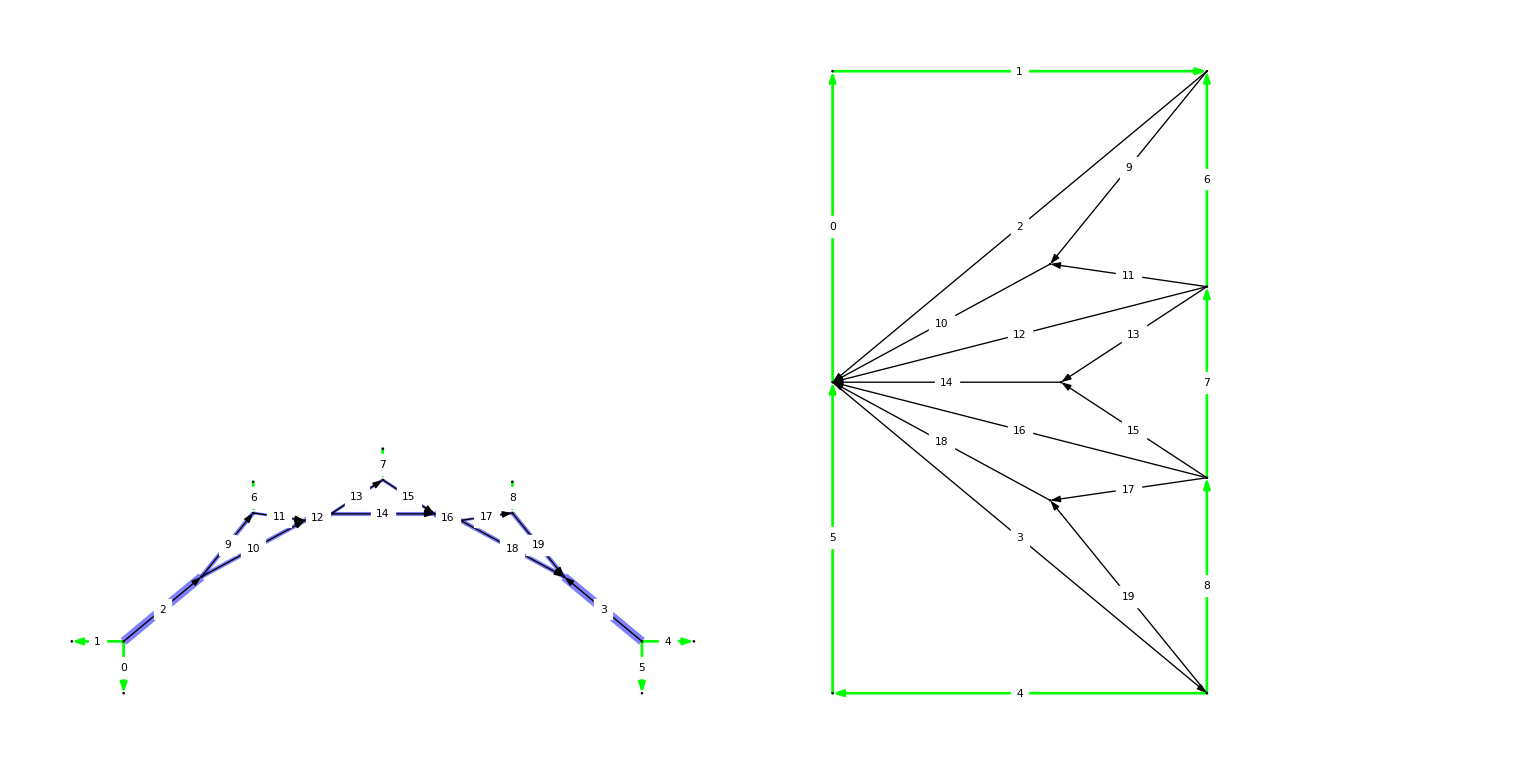

In [20]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=True,
    vertexsize=0.01,
    edgelabel={uv: index for index, uv in enumerate(form.edges())},)

    
viewer.draw_force(
    arrows_on=True,
    vertexsize=0.01,
    edgelabel=viewer.check_edge_pairs()[1])

viewer.show()